## Network visualizations

### Templates
- https://www.pnas.org/doi/full/10.1073/pnas.1803228115
- https://3f53fadb-b5ae-402a-b2a4-47bfe60ade08.usrfiles.com/ugd/3f53fa_fd758b705bc84434892bcb6b42ac278f.pdf


> Hierarchal network model where size of department is operationalized with forms + headcount + services + share of gov.uk domains and link to gov.uk node is number of page visits"

### Potential variables
**Nodes:**
- GOV.UK
- Central government departments

**Node size**
- Number of services
- Number of forms

**Edge:**
- Topics
- Verb

**Edge size**: 
- Number of page visits
- Number of domains

### Building a Scale of Government Map

We model the structure of government as a network. In this network, the nodes are the government organisations (departments). We will experiment with connecting two government agencies with an edge if they have at least one service each that falls under the same topic (e.g., Benefits) or at least one shared verb (e.g., Apply). 

The edge creation process reflects the extent to which two organisations are intrinscially linked. If such a link is present it reflects the fact that two organisations offer similar services and carry out similar functions. The overall structure reveals all the domains of government services and the type of work they do. 

In [1]:
# Load in requisite libraries
import pandas as pd
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations
from itertools import count
from operator import add

In [2]:
# Load in the data that we have to work with
gov_websites = pd.read_csv("../data/processed/201202-201809-central-government-websites.csv",index_col=1)
gov_visitors = pd.read_csv("../data/processed/201104-201203-govuk-unique-visitors-processed.csv")
serv_trans = pd.read_csv("../data/processed/201204-201703-service-transactions-processed.csv")
gov_domains = pd.read_csv("../data/processed/201210-202303-govuk-domain-names.csv")
form_views = pd.read_excel("../data/processed/202211-form-services-pageviews.xlsx",header=1)
gov_forms = pd.read_excel("../data/processed/202212-govuk-departments-with-forms-processed.xlsx")
xgov_services = pd.read_excel("../data/processed/202212-xgov-govuk-services-list.xlsx",index_col=0)
gov_orgs = pd.read_excel("../data/processed/2022-central-government-organisations.xlsx")

In [3]:
xgov_services["topic"].value_counts()

Business and self-employed             59
Driving and transport                  48
Education, training and skills         40
Environment and countryside            32
Crime, justice and the law             30
Money and tax                          23
Benefits                               19
Visas and immigration                  17
Housing and local services             16
Coronavirus (COVID-19)                 16
Passports, travel and living abroad    15
Working, jobs and pensions             13
Citizenship and living in the UK       12
Childcare and parenting                10
Births, deaths, marriages and care      9
Employing people                        2
Name: topic, dtype: int64

In [4]:
# create some subset dfs to merge in the data we want
xgov_services_subset = xgov_services[["organisation","topic"]]
xgov_services_subset = xgov_services_subset.drop_duplicates()
#xgov_services_subset.groupby(["organisation"]).cumcount()
xgov_services_topics = (xgov_services_subset.groupby('organisation')['topic'].apply(list).apply(pd.Series).rename(columns=lambda x: 'topic{}'.format(x+1)))

xgov_services_subset2 = xgov_services[["organisation","verb"]]
xgov_services_subset2 = xgov_services_subset2.drop_duplicates()
#xgov_services_subset.groupby(["organisation"]).cumcount()
xgov_services_verbs = (xgov_services_subset2.groupby('organisation')['verb'].apply(list).apply(pd.Series).rename(columns=lambda x: 'verb{}'.format(x+1)))


In [6]:
# create a final df with all of the info we want for network analysis (all being relative to this version)
gov_forms["organisation"] = gov_forms["organisation"].str.replace('Closed organisation: ', '')
viz_df = pd.DataFrame(xgov_services["organisation"].unique(),columns=["organisation"])
viz_df = pd.merge(viz_df,gov_forms,on="organisation", how="left")
viz_df = viz_df.dropna()
viz_df = pd.merge(viz_df,xgov_services_topics,on="organisation", how="left")
viz_df["topic_list"] =  viz_df[["topic1","topic2","topic3","topic4","topic5","topic6"]].apply(lambda x: x[x.notna()].tolist(), axis=1) 
viz_df = pd.merge(viz_df,xgov_services_verbs,on="organisation", how="left")
filter_col = [col for col in viz_df if col.startswith('verb')]
viz_df["verb_list"] =  viz_df[filter_col].apply(lambda x: x[x.notna()].tolist(), axis=1)
viz_df.head()

# now just need to figure out how to create edges from the topic list column...

,organisation,organisation_type,total,topic1,topic2,topic3,topic4,topic5,topic6,topic_list,...,verb12,verb13,verb14,verb15,verb16,verb17,verb18,verb19,verb20,verb_list
0,HM Courts & Tribunals Service,executive_agency,1066.0,Benefits,"Births, deaths, marriages and care","Crime, justice and the law",Visas and immigration,NaN,NaN,"[Benefits, Births, deaths, marriages and care,...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[Appeal, Respond, Apply, Make, Pay, Reply]"
1,Department for Work and Pensions,ministerial_department,38.0,Benefits,"Births, deaths, marriages and care",Business and self-employed,Childcare and parenting,"Working, jobs and pensions",NaN,"[Benefits, Births, deaths, marriages and care,...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[Apply, Claim, Get, Repay, Report, Send, Unive..."
2,Ministry of Justice,ministerial_department,189.0,"Births, deaths, marriages and care","Crime, justice and the law",NaN,NaN,NaN,NaN,"[Births, deaths, marriages and care, Crime, ju...",...,Use,View,Visit,NaN,NaN,NaN,NaN,NaN,NaN,"[Apply, Appeal, Check, Claim, Employment, Evic..."
3,"Foreign, Commonwealth & Development Office",ministerial_department,80.0,"Births, deaths, marriages and care","Education, training and skills","Passports, travel and living abroad",Coronavirus (COVID-19),NaN,NaN,"[Births, deaths, marriages and care, Education...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[Payment, Check, Apply, Book, Concerned, Forei..."
4,Animal and Plant Health Agency,executive_agency,152.0,Business and self-employed,NaN,NaN,NaN,NaN,NaN,[Business and self-employed],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[Animal, Apply]"


In [7]:
# Creating connections between the nodes is a pain...
# there must be a better way to do this but this is what i could figure out
# this grabs all the orgs with each topic, and then the next cell creates an edge list from all the combinations
xgov_services=xgov_services[xgov_services.organisation.isin(viz_df["organisation"].tolist())] # filter xgov to just our final list 

benefits = list(set(xgov_services["organisation"][xgov_services.topic.isin(['Benefits'])].tolist()))
births_deaths_marriage_care = list(set(xgov_services["organisation"][xgov_services.topic.isin(['Births, deaths, marriages and care'])].tolist()))
business_selfemployed = list(set(xgov_services["organisation"][xgov_services.topic.isin(['Business and self-employed'])].tolist()))
childcare_parenting = list(set(xgov_services["organisation"][xgov_services.topic.isin(['Childcare and parenting'])].tolist()))
citizenship_livinginUK = list(set(xgov_services["organisation"][xgov_services.topic.isin(['Citizenship and living in the UK'])].tolist()))
crime_justice_law = list(set(xgov_services["organisation"][xgov_services.topic.isin(['Crime, justice and the law'])].tolist()))
driving_transport = list(set(xgov_services["organisation"][xgov_services.topic.isin(['Driving and transport'])].tolist()))
education_training_skills = list(set(xgov_services["organisation"][xgov_services.topic.isin(['Education, training and skills'])].tolist()))
environment_countryside = list(set(xgov_services["organisation"][xgov_services.topic.isin(['Environment and countryside'])].tolist()))
housing_localservices = list(set(xgov_services["organisation"][xgov_services.topic.isin(['Housing and local services'])].tolist()))
money_tax = list(set(xgov_services["organisation"][xgov_services.topic.isin(['Money and tax'])].tolist()))
passports_travel_livingabroad = list(set(xgov_services["organisation"][xgov_services.topic.isin(['Passports, travel and living abroad'])].tolist()))
visas_immigration = list(set(xgov_services["organisation"][xgov_services.topic.isin(['Visas and immigration'])].tolist()))
working_jobs_pensions = list(set(xgov_services["organisation"][xgov_services.topic.isin(['Working, jobs and pensions'])].tolist()))
coronavirus = list(set(xgov_services["organisation"][xgov_services.topic.isin(['Coronavirus (COVID-19)'])].tolist()))


In [8]:
elist = []
elist.extend(list(combinations(coronavirus,2)))
elist.extend(list(combinations(working_jobs_pensions,2)))
elist.extend(list(combinations(visas_immigration,2)))
elist.extend(list(combinations(passports_travel_livingabroad,2)))
elist.extend(list(combinations(money_tax,2)))
elist.extend(list(combinations(housing_localservices,2)))
elist.extend(list(combinations(environment_countryside,2)))
elist.extend(list(combinations(education_training_skills,2)))
elist.extend(list(combinations(driving_transport,2)))
elist.extend(list(combinations(crime_justice_law,2)))
elist.extend(list(combinations(citizenship_livinginUK,2)))
elist.extend(list(combinations(childcare_parenting,2)))
elist.extend(list(combinations(business_selfemployed,2)))
elist.extend(list(combinations(births_deaths_marriage_care,2)))
elist.extend(list(combinations(benefits,2)))

In [9]:
# Set up the network 
# nodes are gov orgs
nodes = viz_df["organisation"].tolist()
g = nx.Graph()
g.add_nodes_from(nodes)
# adding edges from orgs that share topics
g.add_edges_from(list(set(map(tuple,map(sorted,elist)))))

# setting some node attributes for later use of visualizing size and color of nodes
nx.set_node_attributes(g, dict(zip(viz_df['organisation'], viz_df['organisation_type'])), "org_type")
nx.set_node_attributes(g, dict(zip(viz_df['organisation'], viz_df['total'])), "form_count")

# had to come back and do this to actually create a color map for the nodes, networkx is a bit annoying
groups = set(nx.get_node_attributes(g,'org_type').values())
mapping = dict(zip(sorted(groups),count()))
nodes = g.nodes()
colors = [mapping[g.nodes[n]['org_type']] for n in nodes] # uses default colors
colors_rgb =list((pd.Series(colors)).map({0:"#ff0000", # pick specific colors for the org types
1:"#00ff00",
2:"#0033cc",
3:"#ff6699",
4:"#ffff00",
5:"#00e6e6"}))

In [10]:
# Edge attributes need to be assembled separately given how our data is set up
# need a list that checks each of these and see how many matching topics
edge_weights_topics = []
for i in range(len(list(g.edges()))):
    gov1 = list(g.edges())[i][0]
    gov2 = list(g.edges())[i][1]
    govlist_1 = viz_df["topic_list"][viz_df["organisation"]==gov1].values[0]
    govlist_2 = viz_df["topic_list"][viz_df["organisation"]==gov2].values[0]
    temp_weight = len([w for w in govlist_1 if w in govlist_2])
    edge_weights_topics.append(temp_weight)
    
print(len(list(g.edges())))
print(len(edge_weights_topics))

263
263


In [11]:
# need a list that checks each of these and see how many matching topics
edge_weights_verbs = []
for i in range(len(list(g.edges()))):
    gov1 = list(g.edges())[i][0]
    gov2 = list(g.edges())[i][1]
    govlist_1 = viz_df["verb_list"][viz_df["organisation"]==gov1].values[0]
    govlist_2 = viz_df["verb_list"][viz_df["organisation"]==gov2].values[0]
    temp_weight = len([w for w in govlist_1 if w in govlist_2])
    edge_weights_verbs.append(temp_weight)
    
print(len(list(g.edges())))
print(len(edge_weights_verbs))

263
263


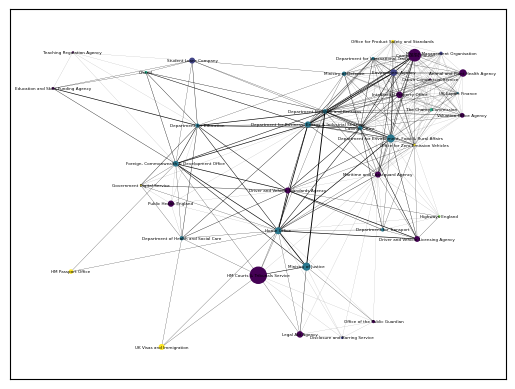

In [13]:
# Basic viz with base networkx
nx.draw_networkx(g, with_labels=True,font_size=3,node_color=colors,node_size=[x / 8 for x in viz_df["total"].tolist()],width=[(x+.5) / 10 for x in edge_weights_verbs])
#list( map(add, edge_weights_verbs, edge_weights_topics) ) # if want to combine topics and verbs


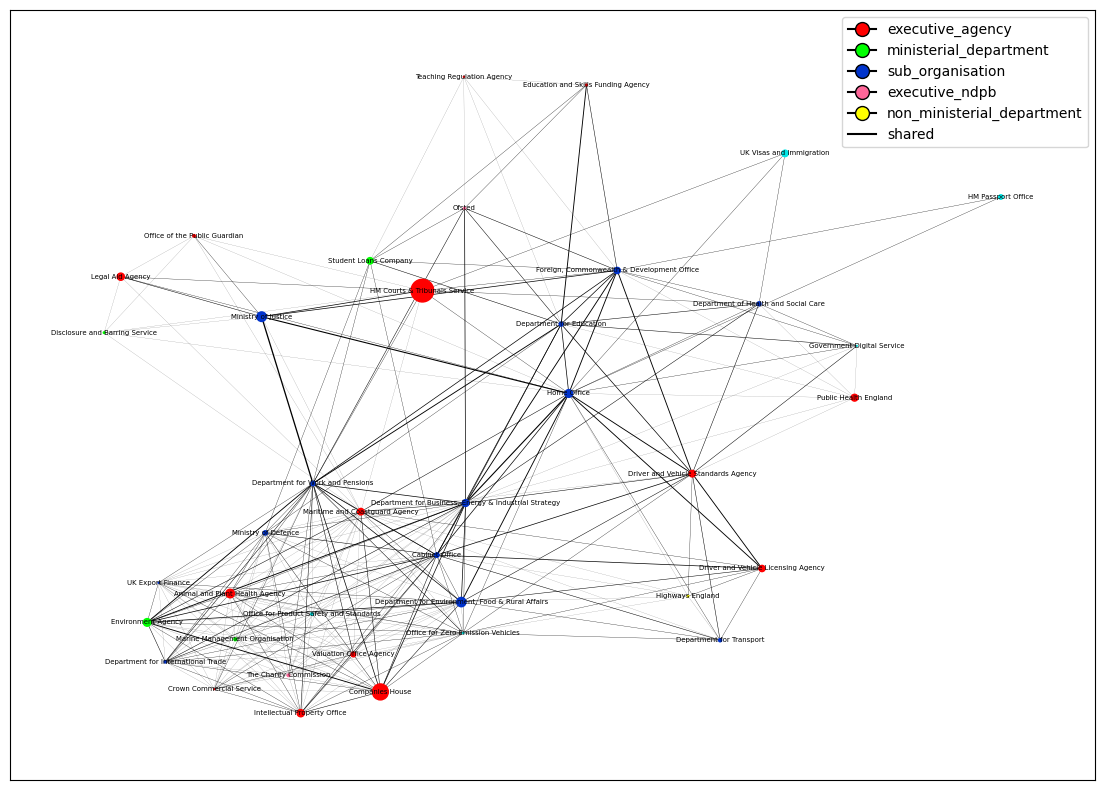

In [140]:
# To get nicer plots you need to use a pre-made layout and bring in some other packages
# Due to the algorithm of spring layout the figure is different every time
from pylab import rcParams
from matplotlib.lines import Line2D
rcParams['figure.figsize'] = 14, 10
pos = nx.spring_layout(g, scale=20, k=3/np.sqrt(g.order()))
nx.draw_networkx(g,
                 with_labels=True,
                 font_size=5,
                 node_color=colors_rgb,
                 node_size=[x / 4 for x in viz_df["total"].tolist()],
                 width=[(x+.5) / 7 for x in edge_weights_verbs])

plt.legend(handles= [
    Line2D([0], [0], marker='o', color='black', label='executive_agency',markerfacecolor='#ff0000', markersize=10),
    Line2D([0], [0], marker='o', color='black', label='ministerial_department',markerfacecolor='#00ff00', markersize=10),   
    Line2D([0], [0], marker='o', color='black', label='sub_organisation',markerfacecolor='#0033cc', markersize=10),   
    Line2D([0], [0], marker='o', color='black', label='executive_ndpb',markerfacecolor='#ff6699', markersize=10),   
    Line2D([0], [0], marker='o', color='black', label='non_ministerial_department',markerfacecolor='#ffff00', markersize=10),
     Line2D([0], [0], marker='none', color='black', label='shared'),
], loc='upper right')
